# Assignment 2 - Machine Learning
**Project:** Project 1 - Classify Images of Road Traffic Signs

**Group Name:** Dan & Ethan
| Name               | Student Number |
|--------------------|----------------|
| Daniel Schellekens | s3900792       |
| Ethan Rayner       | s3902240       |

In [1]:
IMAGES_FILE = "images.csv"
TEST_TRAIN_SPLIT = 0.5

from models.utils import prep_data

data, train_data, val_data = prep_data(IMAGES_FILE, TEST_TRAIN_SPLIT)
data.head()

Test set: 1849 rows
Validation set: 1850 rows


,path,shape,type
0,images\diamond\rightofway\00032_00000.png,diamond,rightofway
1,images\diamond\rightofway\00032_00001.png,diamond,rightofway
2,images\diamond\rightofway\00032_00002.png,diamond,rightofway
3,images\diamond\rightofway\00037_00000.png,diamond,rightofway
4,images\diamond\rightofway\00037_00001.png,diamond,rightofway


Found 1849 validated image filenames belonging to 16 classes.
Found 1850 validated image filenames belonging to 16 classes.


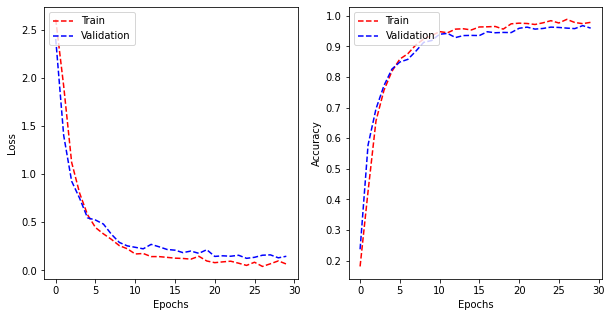

In [2]:
CLASS_COLUMN = "type" 
IMAGE_SIZE = 28
BATCH_SIZE = 32
EPOCHS = 30

import models.vgg as vgg
from models.utils import history_graph
from models.utils import create_generator

vgg_train_images = create_generator(train_data, CLASS_COLUMN, IMAGE_SIZE, BATCH_SIZE)
vgg_val_images = create_generator(val_data, CLASS_COLUMN, IMAGE_SIZE, BATCH_SIZE)
vgg_model, vgg_history = vgg.fit_model(data, CLASS_COLUMN, vgg_train_images, vgg_val_images, IMAGE_SIZE, EPOCHS)
history_graph(vgg_history)

Found 80 validated image filenames belonging to 16 classes.
Accuracy on 500 images: 93.2%


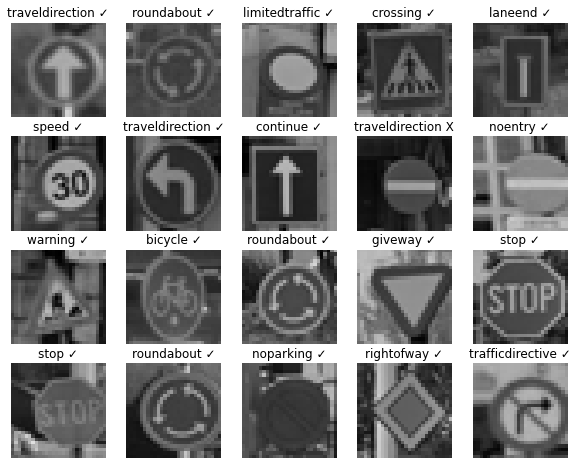

<Figure size 720x14400 with 0 Axes>

In [3]:
NUM_TO_TEST_VISUALLY = 20
NUM_TO_TEST_ACCURACY = 500
IMAGES_FILE = "test-images.csv"

from models.test import create_test_generator
from models.test import show_visual_results
from models.test import score_accuracy

vgg_test_images = create_test_generator(IMAGES_FILE, CLASS_COLUMN, IMAGE_SIZE, 1)
show_visual_results(vgg_model, vgg_test_images, NUM_TO_TEST_VISUALLY)
vgg_test_accuracy = score_accuracy(vgg_model, vgg_test_images, NUM_TO_TEST_ACCURACY)
print("Accuracy on {} images: {:.1f}%".format(NUM_TO_TEST_ACCURACY, vgg_test_accuracy * 100))